**Author**: Petru Potrimba <br>
**Matriculation**:  928850

# Visual Inspection of Motorcycle Connecting Rods

### Utility functions

In [147]:
def defect_convexity_algorithm(img):
    
    contours, hierarchy = cv.findContours(img.copy(), cv.RETR_TREE, cv.CHAIN_APPROX_SIMPLE)
    
    sepc = -1
    for i in range(len(contours)):
        if(len(contours[i])) >= 326: # there are touching elements
            sepc = i
            break
    
    cnt = contours[sepc]
    hull = cv.convexHull(cnt, returnPoints = False)
    defects = cv.convexityDefects(cnt, hull)

    collision_points = []
    
    if sepc != -1: # if sepc is different from "-1", it means that there are touching rods
         for i in range(defects.shape[0]):
            s,e,f,d = defects[i,0]
            far = tuple(cnt[f][0])
            if (far[0] - 1 >= 0) and (far[1] - 1 >= 0) and (far[0] + 1 <= 255) and (far[1] + 1 <= 255) and (far[0] - 2 >= 0) and (far[1] - 2 >= 0) and (far[0] + 2 <= 255) and (far[1] + 2 <= 255):
                octet_sum = int(img[far[1] - 1, far[0]]) + int(img[far[1] - 1, far[0] - 1]) + int(img[far[1], far[0] - 1]) + int(img[far[1] + 1, far[0] - 1]) + int(img[far[1] + 1, far[0]]) + int(img[far[1] + 1, far[0] + 1]) + int(img[far[1], far[0] + 1]) + int(img[far[1] - 1, far[0] + 1]) + int(img[far[1] - 2, far[0]]) + int(img[far[1] - 2, far[0] - 1]) + int(img[far[1] - 2, far[0] - 2]) + int(img[far[1] -1, far[0] - 2]) + int(img[far[1], far[0] - 2]) + int(img[far[1] + 1, far[0] - 2]) + int(img[far[1] + 2,far[0] - 2]) + int(img[far[1] + 2, far[0] - 1]) + int(img[far[1] + 2, far[0]]) + int(img[far[1] + 2, far[0] + 1]) + int(img[far[1] + 2, far[0] + 2]) + int(img[far[1] + 1, far[0] + 2]) + int(img[far[1], far[0] + 2]) + int(img[far[1] - 1, far[0] + 2]) + int(img[far[1] - 2, far[0] + 2]) + int(img[far[1] - 2, far[0] + 1])
                collision_points.append([far, octet_sum, False])
            
    if len(collision_points) > 0:
        # calculate threshold            
        white_pixel_value_sum = []
        for i in range(len(collision_points)):
            white_pixel_value_sum.append(collision_points[i][1])
        remove_duplicate_list = np.sort(list(set(white_pixel_value_sum)))

        changes_between_values = []
        for i in range(len(remove_duplicate_list) - 1):
            changes_between_values.append(remove_duplicate_list[i + 1] - remove_duplicate_list[i])
        max_change = np.argmax(changes_between_values)
        threshold = int(round((remove_duplicate_list[max_change + 1] + remove_duplicate_list[max_change]) / 2))
    

        # calculate euclidean distance
        for i in range(len(collision_points) - 1):
            distance_from_i_to_j = math.inf
            index_of_j = -1
            if collision_points[i][1] <= threshold and collision_points[i][2] == False: # means that still need to find its miniumum distance point
                for j in range(i + 1, len(collision_points)):
                    dst = distance.euclidean([collision_points[i][0][0], collision_points[i][0][1]], [collision_points[j][0][0], collision_points[j][0][1]])
                    if dst < distance_from_i_to_j and collision_points[j][2] == False:
                        distance_from_i_to_j = dst
                        index_of_j = j
                # draw line
                cv.line(img,(collision_points[i][0][0],collision_points[i][0][1]),(collision_points[index_of_j][0][0],collision_points[index_of_j][0][1]),(255,0, 0),1)
                collision_points[i][2] = True
                collision_points[index_of_j][2] = True
                
    return img, collision_points

def compute_width_at_barycenter(barX, barY, contours):
    max_distance_from_bar = - math.inf
    index_of_j = -1
    for j in range(len(contours[i])):
        dst = distance.euclidean([barX, barY], [contours[j][0][0], contours[j][0][1]])
        if dst > max_distance_from_bar:
            max_distance_from_bar = dst
            index_of_j = j

    x1 = contours[index_of_j][0][0]
    x2 = round(barX)
    y1 = contours[index_of_j][0][1]
    y2 = round(barY)
    xdif = x2 - x1
    ydif = y2 - y1

    line_len_at_barycenter = 3

    a1 = int(round(x2 - ydif / line_len_at_barycenter))
    b1 = int(round(y2 + xdif / line_len_at_barycenter))

    a2 = int(round(x2 + ydif / line_len_at_barycenter))
    b2 = int(round(y2 - xdif / line_len_at_barycenter))

    distance_from_i_to_j = math.inf
    index_of_j = -1
    for j in range(len(contours)):
        dst = distance.euclidean([a1, b1], [contours[j][0][0], contours[j][0][1]])
        if dst < distance_from_i_to_j:
            distance_from_i_to_j = dst
            index_of_j = j

    distance_from_i_to_k = math.inf
    index_of_k = -1

    for k in range(len(contours)):
        dst = distance.euclidean([a2, b2], [contours[k][0][0], contours[k][0][1]])
        if dst <= distance_from_i_to_k:
            distance_from_i_to_k = dst
            index_of_k = k
    return distance.euclidean([contours[index_of_j][0][0], contours[index_of_j][0][1]], [contours[index_of_k][0][0], contours[index_of_k][0][1]])

In [148]:
def compute_width_at_barycenter2(barX, barY, contours):
    max_distance_from_bar = - math.inf
    index_of_j = -1
    for j in range(len(contours[i])):
        dst = distance.euclidean([barX, barY], [contours[j][0][0], contours[j][0][1]])
        if dst > max_distance_from_bar:
            max_distance_from_bar = dst
            index_of_j = j

    x1 = contours[index_of_j][0][0]
    x2 = round(barX)
    y1 = contours[index_of_j][0][1]
    y2 = round(barY)
    xdif = x2 - x1
    ydif = y2 - y1

    line_len_at_barycenter = 3

    a1 = int(round(x2 - ydif / line_len_at_barycenter))
    b1 = int(round(y2 + xdif / line_len_at_barycenter))

    a2 = int(round(x2 + ydif / line_len_at_barycenter))
    b2 = int(round(y2 - xdif / line_len_at_barycenter))

    distance_from_i_to_j = math.inf
    index_of_j = -1
    for j in range(len(contours)):
        dst = distance.euclidean([a1, b1], [contours[j][0][0], contours[j][0][1]])
        if dst < distance_from_i_to_j:
            distance_from_i_to_j = dst
            index_of_j = j

    distance_from_i_to_k = math.inf
    index_of_k = -1

    for k in range(len(contours)):
        dst = distance.euclidean([a2, b2], [contours[k][0][0], contours[k][0][1]])
        if dst <= distance_from_i_to_k:
            distance_from_i_to_k = dst
            index_of_k = k
    return contours[index_of_j][0][0], contours[index_of_j][0][1], contours[index_of_k][0][0], contours[index_of_k][0][1]

### Original mage

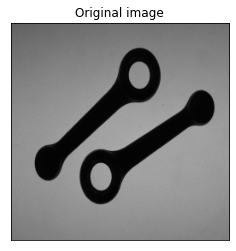

In [421]:
import cv2 as cv
import numpy as np
from matplotlib import pyplot as plt
from scipy.spatial import distance
import math

plt.figure(figsize=(4,4))

original_img = cv.imread('testImages/TESI33.BMP', 0)
img = original_img.copy()
plt.imshow(img, cmap='gray',vmin=0,vmax=255)
plt.title('Original image'), plt.xticks([]), plt.yticks([])
plt.show()

### Apply Otsu's tresholding

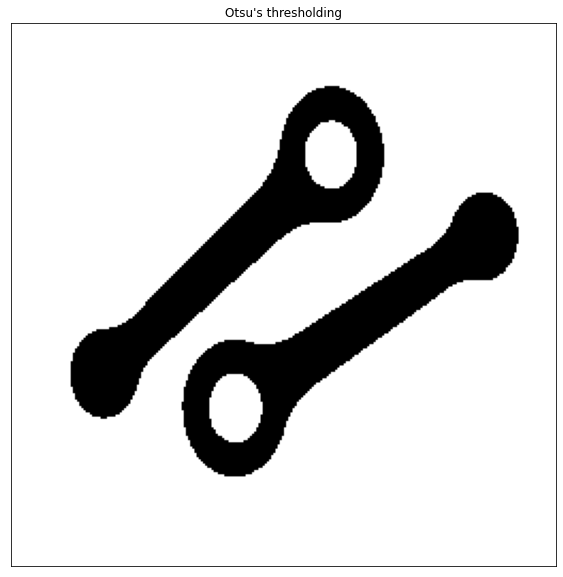

In [422]:
plt.figure(figsize=(10, 10))
ret, otsu_img = cv.threshold(img, 0, 255, cv.THRESH_BINARY+cv.THRESH_OTSU)
plt.imshow(otsu_img,cmap = 'gray')
plt.title('Otsu\'s thresholding'), plt.xticks([]), plt.yticks([])
plt.show()

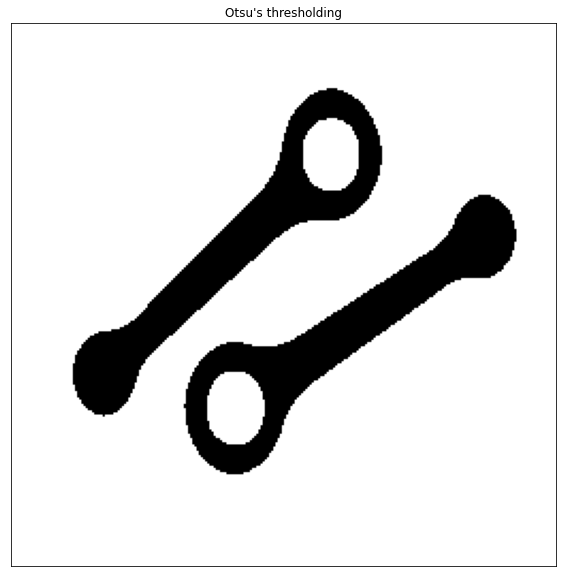

In [423]:
plt.figure(figsize=(10, 10))
kernel = np.ones((3,3), np.uint8) 
img_erosion = cv.dilate(otsu_img, kernel, iterations=1)
plt.imshow(img_erosion,cmap = 'gray')
plt.title('Otsu\'s thresholding'), plt.xticks([]), plt.yticks([])
plt.show()

### Handling touching rods

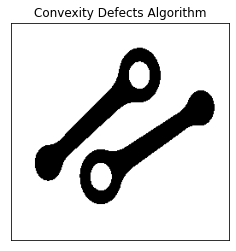

In [424]:
separate_rods_img, c = defect_convexity_algorithm(otsu_img)
plt.imshow(separate_rods_img,cmap = 'gray')
plt.title('Convexity Defects Algorithm'), plt.xticks([]), plt.yticks([])
plt.show()

### Labeling rods type

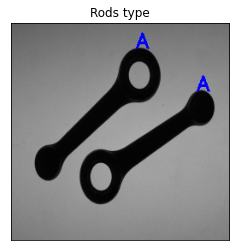

In [425]:
contours, hierarchy = cv.findContours(separate_rods_img.copy(), cv.RETR_TREE, cv.CHAIN_APPROX_SIMPLE)
img = cv.cvtColor(img, cv.COLOR_GRAY2BGR)
for i in range(hierarchy.shape[1]):
    if hierarchy[0, i][3] == 0 and hierarchy[0, i][2] != -1 and len(contours[i]) >= 72:
        if len(hierarchy[:, np.where(hierarchy[0][:, 3] == i)][0][0]) == 1:
            img = cv.putText(img, 'A', (contours[i][0][0][0], contours[i][0][0][1]), cv.FONT_HERSHEY_SIMPLEX, 0.8, (0, 0, 255), 2, cv.LINE_4)
            plt.imshow(img,cmap = 'gray')
            plt.title('Rods type'), plt.xticks([]), plt.yticks([])
        elif len(hierarchy[:, np.where(hierarchy[0][:, 3] == i)][0][0]) > 1:
            img = cv.putText(img, 'B', (contours[i][0][0][0], contours[i][0][0][1]), cv.FONT_HERSHEY_SIMPLEX, 0.8, (0, 0, 255), 2, cv.LINE_4)
            plt.imshow(img,cmap = 'gray')
            plt.title('Rods type'), plt.xticks([]), plt.yticks([])
            
plt.show()

### Position, orientation, length, width and width at the barycenter Wb 

Position:  (155.81167602539062, 139.17819213867188) , Orientation:  51.15517044067383
Length:  188.80502319335938 , Width:  60.074642181396484 , Width at the barycenter(Wb):  26.627053911388696
------------------------------------------------------------------------------------------------
Position:  (103.52941131591797, 112.61763763427734) , Orientation:  42.27368927001953
Length:  196.35317993164062 , Width:  57.04264831542969 , Width at the barycenter(Wb):  55.02726596879042
------------------------------------------------------------------------------------------------


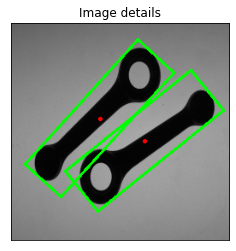

In [426]:
img = original_img.copy()
img = cv.cvtColor(img, cv.COLOR_GRAY2BGR)
for i in range(hierarchy.shape[1]):
    if hierarchy[0, i][3] == 0 and hierarchy[0, i][2] != -1 and len(contours[i]) >= 72: # hierarchy[0, i][3] == 0 : if my parent is zero, it means that I'am a rod.
        rect = cv.minAreaRect(contours[i])                                              # hierarchy[0, i][2] != -1 : if a rod has a first child, it means it is a rod and not a screw, so it will be analyzed.
        box = cv.boxPoints(rect)
        box = np.int0(box)
        img = cv.drawContours(img,[box],0,(0, 255, 0), 2)
        width_at_barycenter = compute_width_at_barycenter(rect[0][0], rect[0][1], contours[i])
        print("Position: ", rect[0], ", Orientation: ", rect[2])
        print("Length: ", rect[1][0] if rect[1][0] > rect[1][1] else rect[1][1], ", Width: ", 
              rect[1][1] if rect[1][1] < rect[1][0] else rect[1][0], ", Width at the barycenter(Wb): ", width_at_barycenter)
        print("------------------------------------------------------------------------------------------------")
        
        # draw barycenter
        img = cv.circle(img, center=(round(rect[0][0]), round(rect[0][1])), radius=1, color=(255, 0, 0) , thickness=2) 
        plt.imshow(img, cmap = 'gray')
        plt.title('Image details'), plt.xticks([]), plt.yticks([])
plt.show()

51.15517044067383
42.27368927001953


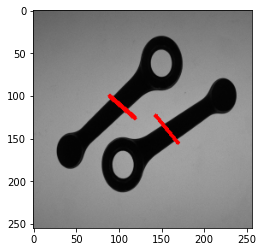

In [427]:
img = cv.cvtColor(original_img, cv.COLOR_GRAY2BGR)
for i in range(hierarchy.shape[1]):
    if hierarchy[0, i][3] == 0 and hierarchy[0, i][2] != -1 and len(contours[i]) >= 72: # hierarchy[0, i][3] == 0 : if my parent is zero, it means that I'am a rod.
        rect = cv.minAreaRect(contours[i])                                              # hierarchy[0, i][2] != -1 : if a rod has a first child, it means it is a rod and not a screw, so it will be analyzed.
        box = cv.boxPoints(rect)
        box = np.int0(box)
        x,y,k,o = compute_width_at_barycenter2(rect[0][0], rect[0][1], contours[i])
        #print(rect[2])
        #if rect[2] == 69.59979248046875:
        print(rect[2])
        angle1 = rect[2]
        angle2 = 180+rect[2]
        if rect[2] <= 0 or (rect[2] >= 69 and rect[2] < 70):
            angle1 = rect[2]+90
            angle2 = 180+rect[2]+90
        a,b,c,d = get_coords(round(rect[0][0]), round(rect[0][1]), angle1)
        cv.line(img,(round(rect[0][0]), round(rect[0][1])),(c,d),(255,0, 0),3)

        a,b,c,d = get_coords(round(rect[0][0]), round(rect[0][1]), angle2)
        cv.line(img,(round(rect[0][0]), round(rect[0][1])),(c,d),(255,0, 0),3)
        plt.imshow(img, cmap = 'gray')
        
plt.show()

In [420]:
import numpy as np
import math
import matplotlib.pyplot as plt

In [412]:
import math

def get_coords(x, y, angle):

    length = 20
    endx1 = x + length * math.cos(math.radians(angle))
    endy1 = y + length * math.sin(math.radians(angle))

    endx2 = x + length * math.cos(math.radians(angle+180))
    endy2 = y + length * math.sin(math.radians(angle+180))

    return round(endx1), round(endy1), round(endx2), round(endy2)

In [377]:
img.shape

(255, 256, 3)

### For each hole, position of the centre and diameter size

Centre position:  (132.80734252929688, 175.95468139648438)
Diameter:  22.536361694335938
------------------------------------------------------------------------------------------------
Centre position:  (213.74658203125, 153.56207275390625)
Diameter:  25.171432495117188
------------------------------------------------------------------------------------------------
Centre position:  (43.35325241088867, 128.28004455566406)
Diameter:  23.737041473388672
------------------------------------------------------------------------------------------------
Centre position:  (99.17955017089844, 169.0199737548828)
Diameter:  24.14182186126709
------------------------------------------------------------------------------------------------


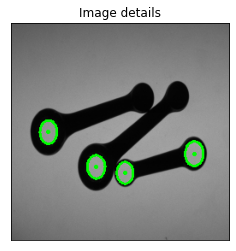

In [17]:
img = original_img.copy()
img = cv.cvtColor(img, cv.COLOR_GRAY2BGR)
for i in range(hierarchy.shape[1]):
    if hierarchy[0, i][3] > 0 and len(contours[i]) > 24 and len(contours[hierarchy[0, i][3]]) >= 72: # if the parent of the hole has a perimeter greater than 72 (basically here I am verifying whether the hole's parent is a rod)
        (x, y), (MA, ma), angle = cv.fitEllipse(contours[i])
        ellipse = cv.fitEllipse(contours[i])
        img = cv.ellipse(img ,ellipse,(0,255,0),2)
        print("Centre position: ", (x, y))
        print("Diameter: ", (MA + ma) / 2)
        print("------------------------------------------------------------------------------------------------")
        
        # draw barycenter
        img = cv.circle(img, center=(round(x), round(y)), radius=1, color=(0, 255, 0) , thickness=2) 
        plt.imshow(img, cmap = 'gray')
        plt.title('Image details'), plt.xticks([]), plt.yticks([])
plt.show()

# Project report

## First Task

### Type of rod (A or B)

In order to understand whether a rod has one hole (type A) or two holes (type B), the idea is to use the OpenCV function `findContours` which returns a hierarchical matrix that specifies, for each blob contour, the information regarding which is the **next** contour at its same level, the **previous** contour at its same level, who is its **first child** and who is its **parent**.

Using these information it will be easy to classify whether a rod is of type A or B.

But, in order to apply that function, we need to segment the blobs, so the first thing to do is a **segmentation**. <br>
The segmentation algorithm I decided to use is the **Otsu's segmentation** since it effectively calculate an automatic threshold even though the images have been taken by a different lighting power.

### Position and orientation (modulo $\pi$)

The position and orientation of the blobs have been calculated using the OpenCV function `minAreaRect` which returns a Box2D structure which contains following details: $$ rect = [center (x,y), \space(width, height), \space angle \space of \space rotation]$$

where *center(x, y)* represents the coordinates of the blob barycenter, *width* and *height* are the size of the MER and *angle of rotation* is the orientation of the blob. <br>

The **position** of the objects has been underlined drawing the MER of each blob. To draw the MER I needed to calculate first its 4 corners using the function `boxPoints(rect)` where the argument *rect* is the output returned by *minAreaRect*.


The **orientation** is the *angle of rotation* given by the *minAreaRect* function.

### Length (L), Width (W), Width at the barycenter ($W_B$)

The **length** coincide with the *height* whereas the **width** coincide with the *width* (both given by *minAreaRect* function).

The width at the barycenter **$W_B$** is computed by the function I implemented `compute_width_at_barycenter`. <br>
The function performs the following steps:
     - for each rod:
        - draw its minor axis and give it a generic length.
        - for both extremes of this line, compute which is its nearest rod contour pixel. This step outputs
          therefore two points.
        - then, the width at the barycenter is given by the Euclidean distance between the two points found
          previously.

Below is shown an example of the points (in red) that my algorithm finds for a single rod:

<img src="img_project/width_at_barycenter.png">

### For each hole, position of the centre and diameter size

To accomplish this task I used the function `fitEllipse` that fits an ellipse around a set of 2D points. <br>
This function returns the following details: 
$$ ellipse = [center (x,y), \space(Major \space axis, Minor \space axis), \space angle \space of \space rotation]$$

where *center(x, y)* represents the coordinates of the circle barycenter, *Major axis* and *Minor axis* are the length of the Major and Minor axis of the circle and *angle of rotation* is the orientation of the circle.

The **hole position** coincides with the *center(x, y)*, while the **hole diameter size** has been calculated as follows: 

$$\frac{Major \space axis + Minor \space axis}{2}$$

I decided to calculate the hole diameter size in that way because of the holes distorsion. So, in order to get a better approximation, I decided to take the mean between the Major and Minor axis.

## Second Task

### Images may contain other objects

In order to understand whether a blob is a **screw** it was sufficient to analyze the hierarchical matrix returned by `findContours` function. If the contour of a blob has not any child, that simply means that is not a rod but a screw.

On the other hand, to understand whether a blob is a **washer** I calculate the minimum perimeter of a rod (80 pixel) and the maximum perimeter of a washer (64 pixel) and I calculate a threshold as $\frac{(80 + 64)}{2} = 72$. So, if the perimeter of a blob was greater than or equal than that parameter, it means that that blob is not a washer.

### Rods can have contact points

The function that handles touching rods is the function I implemented `defect_convexity_algorithm`.

To achieve this task, the first thing to do was to understand whether in the image there were contact points between rods.
To do so, I calculate the maximum perimeter of a rod (256 pixel) and the minimum perimeter of rods that contact each other (397 pixel) and, as before, calculate a threshold as $\frac{(256 + 397)}{2} = 326$. So, if a blob has a perimeter greater than or equal than parameter, it means that there are rods that touch each other.

Then, I used the function `convexityDefects` that finds the convexity defects of a contour.
However, not every point that this function returns indicate a contact between rods. Therefore, to select only the interesting points, I decided to count how many white pixels a defect point has in a $5 \times 5$ window and check whether there are some evident patterns between defect points that indicate a contact between rods and defect points that do not. Below I show the plots I obtained of two test images where there are touching rods:

<img src="img_project/defect_points1.png" width="40%" height="40%">
<img src="img_project/defect_points2.png" width="40%" height="40%">

Is can be clearly noticed that there is a sharp variation between some points. The points that has a low value are indeed the defect points that indicate a contact point between rods.

Now, in order to tell apart these points I calculate an automatic threshold as follows:
    - consider the defect points values and remove the duplicate values
    - order them. Suppose the values we have so far are these [ 510,  765, 3060, 3315]
    - then calculate which are the values pair that shows the maximum variation, in this case 3060 - 765 = 2295.
    - the threshold is computed by dividing by 2 the maximum variation value, so 2295/2 = 1147 would be
      the threshold to select.

Once we know which are the points that indicate a contact between rods, I calculate, for each point, who is its nearest point using the Euclidean distance and draw a white straight line between them. This lead indeed into a separation between the rods.

### Scattered iron powder noise

To solve this task, at the beginning I tried different solutions like applying median filter and closing operations 
to erase the powder noise. However, these operations did not work so well since, in some circumstances, they deformed the rods structure. So I decided to keep the noise in the images and just do not consider them during the analysis. <br> 
To understand whether a blob is a noisy blob or not, I calculate the maximum perimeter of a noisy blob (12 pixel) and the minimum perimeter of non noisy blob (35 pixel) and, as before, calculate a threshold as $\frac{(12 + 35)}{2} = 24$